In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
from datetime import datetime as dt
import time
import csv

import json

In [2]:
rawGames = pd.read_csv('SteamAppsInfo.csv', encoding = "ISO-8859-1")

In [3]:
rawGames

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
0,1688200,War Of Gold,"Tero Lunkka,Valkeala Software","Aug 22, 2021",0.59,15.0,66%,"['Action', 'Casual', 'Indie']","['Casual', 'Action', '3D Fighter', 'Shooter', ...",All Games,False,You super hero soldier need save robber gold b...,False
1,1688210,Utopia,Iconic Ideaz,"Jan 7, 2022",NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","['Early Access', 'RPG', 'Survival', 'Colorful'...",All Games,False,UTOPIA is an open world survival game set in a...,False
2,1688220,Fire & Reign,Siphon Shock,Jun 2022,NaN,NaN,NaN,"['Action', 'Indie']","['Bullet Hell', 'Action', ""Shoot 'Em Up"", 'Sho...",All Games,False,Upgrade your warriors and shoot through waves ...,False
3,1688240,Escape from the Office,"ParachuteGames, ImperiumGame","Jul 26, 2021",2.99,12.0,91%,"['Action', 'Indie']","['Action', 'Precision Platformer', 'Perma Deat...",All Games,False,Escape from the Office is a 2D side-scrolling ...,False
4,1688250,PRINCESS IN AIRINESS,Broken Desk,"Jul 26, 2021",3.99,2.0,NaN,"['Action', 'Indie']","['Action', 'Point & Click', '2D Platformer', '...",All Games,False,"To pray for peace, the princess once again fli...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113005,1972180,Dub Club,Cyberfunk Studios LLC,"May 20, 2022",0.00,NaN,NaN,"['Casual', 'Free to Play']","['Casual', 'Rhythm', 'Exploration', 'Third Per...",All Games,False,A third person multiplayer virtual music venue...,False
113006,1595760,ScreenSpace,Wave Project,"Apr 23, 2021",1.99,1.0,NaN,"['Casual', 'Indie']","['Casual', 'Clicker', 'Arcade', 'Point & Click...",All Games,False,Test your focus and reflexes in this simplisti...,False
113007,1996680,Fowl Scourge,Void Cup Games,When its done,NaN,NaN,NaN,"['Action', 'Indie', 'RPG']",[],All Games,False,In this Dark Fantasy Action-RPG you are part o...,False
113008,1972250,Project: Maidenless,Grossly Incandescent Games,TBA,NaN,NaN,NaN,"['Action', 'Adventure', 'Indie', 'Massively Mu...","['Early Access', 'Action', 'Adventure', 'RPG',...",All Games,False,Scavenge for loot in an unforgiving world fill...,False


In [4]:
#Now to try and get the dates.
#
#Note that this script eliminates dates which don't fit certain date formats.
#
#For example, it converts "Coming Soon" to NaN.
def datesCleaned(dataframe):
    
    datesCleaned = [];
    
    #Convert to dt format
    for i in dataframe['releaseDate']:
        try:
            datesCleaned.append(dt.strptime(i, '%b %d, %Y'))
        except:
            try:
                datesCleaned.append(dt.strptime(i, '%b, %Y'))
                
            except:
                try: datesCleaned.append(dt.strptime(i, '%b %Y'))
                    
                except:
                    datesCleaned.append(np.nan)
            
    datesCleanedSeries = pd.Series(datesCleaned)
    
    datesCleanedSeries.index = dataframe.index
    
    return datesCleanedSeries

datesCleaned = datesCleaned(rawGames)

#Replece release dates with cleaned dates
rawGames['releaseDate'] = datesCleaned
        
# #Add cleaned release dates to dataframes
# ncrpgs_df['releaseDate'] = rpgDatesCleaned[ncrpgs_df.index]
# crpgs_df['releaseDate'] = rpgDatesCleaned[crpgs_df.index]

In [5]:
#Clean all the game tags
def tagsCleaned(games):
    
    tagsCleaned = []
    
    for k in games.index:
        
        #Get rid of \' \s \em etc.
        tagsRemovedSlashes = re.findall(r"'(.*?)'[,\]]",games.tagsList[k]\
                                        .replace("\'s","s").replace("\'em","em")\
                                        .replace("\'Em","Em").replace("\'","''"))
        
        tagsCleaned.append([tagsRemovedSlashes[j].replace("'","") for j in range(len(tagsRemovedSlashes))])
        
    tagsCleanedSeries = pd.Series(tagsCleaned)
    
    tagsCleanedSeries.index = games.index
        
    return tagsCleanedSeries

rawGames['tagsList'] = tagsCleaned(rawGames)

print(rawGames['tagsList'][0])

['Casual', 'Action', '3D Fighter', 'Shooter', 'Runner', 'Real Time Tactics', 'Hero Shooter', '3D', 'Military', 'Stealth', 'Flight', 'Survival', 'Story Rich', 'Combat', 'Singleplayer', 'Third-Person Shooter', 'Vehicular Combat', 'Indie', 'First-Person', 'Character Customization']


In [6]:
#Find all non-DLC RPGs and CRPGs
rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])
                 for i in range(len(rawGames))]][rawGames['dlcBool'] == False]

C:\Users\phyis\AppData\Local\Temp/ipykernel_23420/183280176.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])


In [102]:
def tagBool(games,tagNames):
    
    #Check for a tag name in every game in dataframe
    tagBoolSeries = pd.Series([any([tagName in games['tagsList'][j] for tagName in tagNames]) for j in games.index])
    
    tagBoolSeries.index = games.index
    return tagBoolSeries

#Get list of Booleans corresponding to whether the game is a CRPG
crpgBool = tagBool(rpgs, ['CRPG'])

In [8]:
#All CRPGs
crpgs_df = rpgs.copy()[crpgBool.tolist()]

#All non-CRPG RPGs (nCRPGs)
ncrpgs_df = rpgs.copy()[np.logical_not(crpgBool.tolist())]

In [9]:
any([True,False])

True

In [10]:
ncrpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
1,1688210,Utopia,Iconic Ideaz,2022-01-07,NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","[Early Access, RPG, Survival, Colorful, Base B...",All Games,False,UTOPIA is an open world survival game set in a...,False
8,1688320,OneBit Adventure,"Galactic Slice, LLC",2022-08-05,0.00,NaN,NaN,"['Adventure', 'Casual', 'Free to Play', 'Indie...","[Roguelite, Roguelike, Class-Based, Dungeon Cr...",All Games,False,OneBit Adventure is a casual turn-based roguel...,False
26,1688600,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
27,1688630,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
28,1688640,Cleanup on Isle Goblin,Kilowatt Games,NaT,NaN,NaN,NaN,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Life Sim, RPG, Pixel Graphics, Adventure, Cra...",All Games,False,Isle Goblin has been invaded by destructive hu...,False


In [11]:
crpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
218,1686130,Deep Despair 2,BekkerDev Studio,2021-10-08,6.99,67.0,88%,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Sandbox, Crafting, Adventure, Survival, Simul...",All Games,False,Deep Despair 2 is an open world survival adven...,False
458,1684240,Metal Faith,Youth Game,2021-08-02,9.99,NaN,NaN,"['Adventure', 'Indie', 'RPG']","[Adventure, RPG, Action-Adventure, Shooter, Pu...",All Games,False,A 3D adventure puzzle game,False
459,1684250,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
464,1684310,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
479,1683870,Crystalreach Islands,Majao Games,NaT,NaN,NaN,NaN,['RPG'],"[RPG, Fantasy, Action RPG, Open World, Sandbox...",All Games,False,Crystalreach Islands is an open-world action R...,False


In [12]:
rpgs.tagsList.replace("\'s","s").replace("\'em","em").replace("\'Em","Em").replace("\'","''")

1         [Early Access, RPG, Survival, Colorful, Base B...
8         [Roguelite, Roguelike, Class-Based, Dungeon Cr...
26        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
27        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
28        [Life Sim, RPG, Pixel Graphics, Adventure, Cra...
                                ...                        
112994    [Casual, Adventure, RPG, JRPG, Turn-Based Tact...
112995    [RPG, Action RPG, 2D Platformer, Pixel Graphic...
113003    [Strategy, Grand Strategy, Turn-Based Strategy...
113004    [Action, RPG, 2D Fighter, 3D Fighter, JRPG, 3D...
113008    [Early Access, Action, Adventure, RPG, Action ...
Name: tagsList, Length: 15689, dtype: object

In [13]:
rpgDates = datesCleaned[rpgs.index]

In [14]:
#Count number of games over the years
def gameGrowth(games,start_date):
    end_date = dt.now().year

    dates = range(start_date,end_date+1)

    gamesCount=[]
    for date in dates:
        #How many games were released before "date"?
        gamesCount.append(len(games[[games['releaseDate'][i].year < date for i in games.index]].index))
        
    return gamesCount

In [30]:
array = [['a','b'], ['a', 'b','c'], ['a']]
result = {x for l in array for x in l}
print(result)

{'b', 'a', 'c'}


In [63]:
print(rawGames.appGenre)

0                             ['Action', 'Casual', 'Indie']
1         ['Action', 'Adventure', 'Massively Multiplayer...
2                                       ['Action', 'Indie']
3                                       ['Action', 'Indie']
4                                       ['Action', 'Indie']
                                ...                        
113005                           ['Casual', 'Free to Play']
113006                                  ['Casual', 'Indie']
113007                           ['Action', 'Indie', 'RPG']
113008    ['Action', 'Adventure', 'Indie', 'Massively Mu...
113009                                           ['Action']
Name: appGenre, Length: 113010, dtype: object


In [51]:
pd.Series([j for i in range(len(rawGames.appGenre)) for j in rawGames.appGenre[i]]).unique()

TypeError: 'float' object is not iterable

In [65]:
pd.Series([j for i in range(len(rawGames.tagsList)) for j in rawGames.tagsList[i]]).unique()[0]

'Casual'

In [79]:
tuple(['dog']+[ x for x in [1,2,3]])

('dog', 1, 2, 3)

In [115]:
#Find number of games with each tag in every year since oldest game on Steam

from os.path import exists

startDate = min(rawGames['releaseDate']).year
endDate = dt.now().year

#All unique tag names
uniqueTagNames = pd.Series([j for i in range(len(rawGames.tagsList)) for j in rawGames.tagsList[i]]).unique()

startTime = time.time()

if exists('SteamGamesTimeSeries.csv'):
    gamesTimeSeries = pd.read_csv('SteamGamesTimeSeries.csv')
    timeSeriesCSV.close()
    print('SteamGamesTimeSeries already exists.')

else:
    timeSeriesCSV = open('SteamGamesTimeSeries.csv','w+')
    writer = csv.writer(timeSeriesCSV)
    writer.writerow(tuple(['tagName']+[i for i in range(startDate,endDate+1)]))
    
    for tag in uniqueTagNames:
        dates = range(startDate,endDate+1)

        gamesCount=[]
        for date in dates:
            #How many games with this tag were released before "date"?
            
            tagGames = rawGames[tagBool(rawGames,[tag])]

            gamesCount.append(len(tagGames[[tagGames['releaseDate'][i].year < date for i in tagGames.index]].index))
            
        writer.writerow(tuple([tag] + gamesCount))
        
    timeSeriesCSV.close()
    
print(time.time() - startTime)
            
        

    

12764.020555973053


In [15]:
allGamesCount = gameGrowth(rawGames,min(ncrpgs_df['releaseDate']).year)

In [16]:
ncrpgCount = gameGrowth(ncrpgs_df,min(ncrpgs_df['releaseDate']).year)

In [17]:
crpgCount = gameGrowth(crpgs_df,min(ncrpgs_df['releaseDate']).year)

In [61]:
#How much porn is there on Steam?
startTime = time.time()
pornBool = tagBool(rawGames,['Nudity','Hentai','Mature'])
pornGames = rawGames[pornBool]


pornGamesCount = gameGrowth(pornGames,1985)

print(time.time() - startTime)

4.763958215713501


In [19]:
pornGames.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
7,1688310,Perfect Affection Plan: Cassiopeia,Genesis Arthangel,2021-07-20,14.99,2.0,NaN,['Simulation'],"[Sexual Content, Simulation, Clicker, 2D, Anim...",All Games,False,"Kaede Uzuki, Everyone loves her, but finds lon...",False
57,1688000,My Cute Pagangirl - FREE Girls pack,CUTE ANIME GIRLS,2021-07-22,0.00,5.0,NaN,"['Adventure', 'Casual', 'Indie']","[Adventure, Indie, Casual, Nudity, Sexual Cont...",All Games,True,DLC ! GIRLS MODE .,True
124,1687780,THE ADVENTURES OF LWANDA MAGERE,Bethuel K. Okelo,2021-09-10,4.99,2.0,NaN,"['Action', 'Adventure', 'Indie']","[Adventure, Action, Singleplayer, Action-Adven...",All Games,False,This is an action-adventure game based on the ...,False
159,1687170,Buoy,Dmitry Klimov,NaT,NaN,NaN,NaN,"['Adventure', 'Indie', 'RPG', 'Simulation', 'E...","[Adventure, Survival, Crafting, Building, Mult...",All Games,False,After the cataclysm that occurred on planet Ea...,False
169,1687400,Pixie Farm VR / VR,kan.kikuchi,NaT,NaN,NaN,NaN,['Simulation'],"[Simulation, VR, Anime, Cute, Hentai, Roguelit...",All Games,False,Pixie Farm VR is a pixie raising simulation VR...,False


In [154]:
tagTS = pd.read_csv('SteamGamesTimeSeries.csv',index_col=0)

In [161]:
tagTS.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
tagName,,,,,,,,,,,,,,,,,,,,,
Casual,0,0,0,0,0,0,0,0,0,0,...,1136,1501,2360,3791,6403,10180,15357,20301,26642,36105
Action,0,1,1,1,1,1,1,1,1,1,...,2356,3014,4116,6030,9101,13361,18650,24300,30835,40036
3D Fighter,0,0,0,0,0,0,0,0,0,0,...,6,7,11,13,21,34,45,67,182,439
Shooter,0,0,0,0,0,0,0,0,0,0,...,710,803,1002,1246,1577,2038,2568,3129,4339,6129
Runner,0,0,0,0,0,0,0,0,0,0,...,6,11,21,39,75,119,180,240,423,832


In [174]:
#Function to plot number of games with certain tags over time
def tagNumberPlot(tagNameList):
    plt.figure()

    #Define time range: oldest game on steam to current year
    startDate = min(rawGames['releaseDate']).year
    endDate = dt.now().year
    
    dates = range(startDate,endDate+1)
    
    #Plot all tag time series
    for tag in tagNameList:
        plt.plot(dates, tagTS.loc[tag].values, label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Number games')

    plt.grid()
    plt.legend()
    return

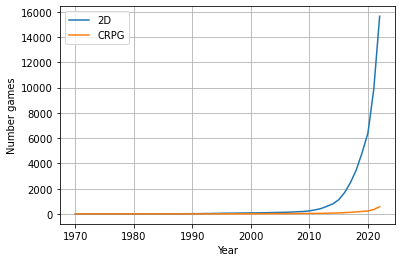

In [177]:
tagNumberPlot(['2D','CRPG'])

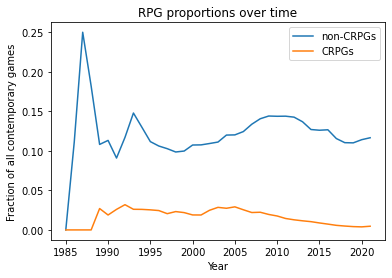

In [21]:
#Plot change in proportion of RPGs over time
plt.figure()

dates = range(min(ncrpgs_df['releaseDate']).year,dt.now().year)

plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [ncrpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='non-CRPGs')
plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [crpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='CRPGs')
# plt.plot(dates, crpgCount)

plt.title('RPG proportions over time')
plt.xlabel('Year')
plt.ylabel('Fraction of all contemporary games')

plt.legend()

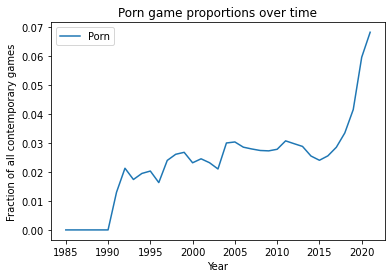

In [22]:
#Plot change in proportion of RPGs over time
plt.figure()

dates = range(1985,dt.now().year)

plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [pornGamesCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='Porn')


plt.title('Porn game proportions over time')
plt.xlabel('Year')
plt.ylabel('Fraction of all contemporary games')

plt.legend()